# 1D
## Dirichlet

In [32]:
import numpy as np
from pypde.bases.chebyshev import *
from numpy.linalg import solve
from pypde.solver.matrix import *
from pypde.solver.operator import *
from pypde.field import SpectralField
import matplotlib.pyplot as plt

def _f(x):
        return np.cos(1*np.pi/2*x)
def _u(x):
        return -np.cos(1*np.pi/2*x)*(1*np.pi/2)**-2
    
N = 100

u = SpectralField(N+2, "ChebDirichlet")
x = u.x
f = SpectralField(N+2, "ChebDirichlet")

S = u.xs[0].S
B = u.xs[0].B(2)@S
A = u.xs[0].I()@S

# -- RHS ---
f.v = _f(x)
f.forward()
b = RHSExplicit(f=(B@f.vhat))

# -- LHS ---
A0 = MatrixLHS(A,ndim=1,axis=0, solver="solve")                 
A0 = LHSImplicit(A0)

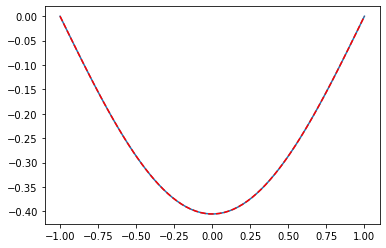

In [27]:
u.vhat = A0.solve(b.rhs)
u.backward()

plt.plot(x,u.v)
plt.plot(x,_u(x),"r--")
plt.show()

## Neumann

In [11]:
import numpy as np
from pypde.bases.chebyshev import *
from numpy.linalg import solve
from pypde.solver.matrix import *
from pypde.solver.operator import *
from pypde.field import SpectralField
import matplotlib.pyplot as plt

def _f(x):
        return np.sin(1*np.pi/2*x)
def _u(x):
        return -np.sin(1*np.pi/2*x)*(1*np.pi/2)**-2
    
N = 100
skipfirst = True
skip = slice(1,None) if skipfirst else slice(0,None)

u = SpectralField(N+2, "ChebNeumann")
x = u.x
f = SpectralField(N+2, "ChebNeumann")

S = u.xs[0].S
B = u.xs[0].B(2)@S
A = u.xs[0].I()@S


# -- RHS ---
f.v = _f(x)
f.forward()
b = RHSExplicit(f=(B[skip,skip]@f.vhat[skip]))

# -- LHS ---
A0 = MatrixLHS(A[skip,skip],ndim=1,axis=0, solver="solve")                 
A0 = LHSImplicit(A0)


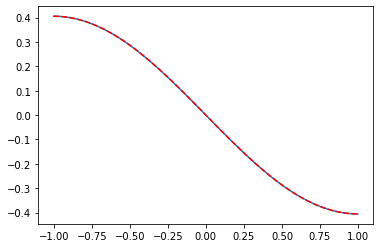

In [12]:

u.vhat[skip] = A0.solve(b.rhs)
u.backward()

plt.plot(x,u.v)
plt.plot(x,_u(x),"r--")
plt.show()

# 2D
## Dirichlet

In [29]:
import numpy as np
from pypde.bases.chebyshev import *
from numpy.linalg import solve
from pypde.solver.matrix import *
from pypde.solver.operator import *
from pypde.field import SpectralField
import matplotlib.pyplot as plt
from pypde.utils import eigen_decomp

ARG = np.pi/2

def _f(xx,yy):
        return np.cos(ARG*xx)*np.cos(ARG*yy)
def _u(xx,yy):
        return np.cos(ARG*xx)*np.cos(ARG*yy)*-1/ARG**2/2
    
N = 20
shape = (N+2,N+2)
skipfirst = False
skip = slice(1,None) if skipfirst else slice(0,None)

u = SpectralField(shape, ("CD","CD"))
f = SpectralField(shape, ("CD","CD"))
x,y = u.x,u.y; xx,yy = np.meshgrid(x,y)

S = u.xs[0].S
B = u.xs[0].B(2)@S
A = u.xs[0].I()@S

BI = np.linalg.inv(B)
w,Q,Qi = eigen_decomp(A.T@BI.T)
    
# -- RHS ---
f.v = _f(xx,yy)
f.forward()
b = RHSExplicit(f=f.vhat)
b.add_PM(MatrixRHS(B[skip,skip],axis=0))
b.add_PM(MatrixRHS(Q.T[skip,skip],axis=1))

# -- LHS ---
Ax = MatrixLHS(A=B[skip,skip],ndim=2,axis=0,
    solver="poisson",lam=w,C=A[skip,skip])
Ay = MatrixLHS(A=Qi.T[skip,skip],ndim=2,axis=1,
    solver="matmul")
A = LHSImplicit(Ax)
A.add(Ay)

(20, 20)


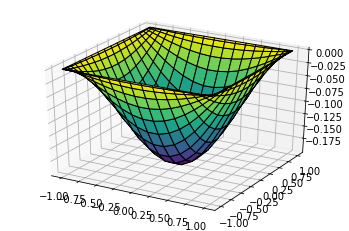

In [30]:
print(b.rhs.shape)
u.vhat[skip,skip] = A.solve(b.rhs)
u.backward()

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(xx,yy,u.v, rstride=1, cstride=1, cmap="viridis",edgecolor="k")
plt.show()

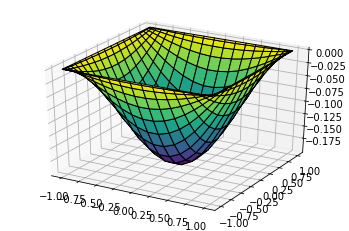

In [31]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(xx,yy,_u(xx,yy), rstride=1, cstride=1, cmap="viridis",edgecolor="k")
plt.show()

## Neumann

In [54]:
import numpy as np
from pypde.bases.chebyshev import *
from numpy.linalg import solve
from pypde.solver.matrix import *
from pypde.solver.operator import *
from pypde.field import SpectralField
import matplotlib.pyplot as plt
from pypde.utils import eigen_decomp

ARG = np.pi/2

def _f(xx,yy):
        return np.sin(ARG*xx)*np.sin(ARG*yy)
def _u(xx,yy):
        return np.sin(ARG*xx)*np.sin(ARG*yy)*-1/ARG**2/2
    
N = 20
shape = (N+2,N+2)
skipfirst = True
skip = slice(1,None) if skipfirst else slice(0,None)

u = SpectralField(shape, ("CN","CN"))
f = SpectralField(shape, ("CN","CN"))
x,y = u.x,u.y; xx,yy = np.meshgrid(x,y)

S = u.xs[0].S
B = u.xs[0].B(2)@S
A = u.xs[0].I()@S

BI = np.linalg.inv(B)
w,Q,Qi = eigen_decomp(A.T@BI.T)
    
# -- RHS ---
f.v = _f(xx,yy)
f.forward()
fhat = f.vhat[skip,skip]
b = RHSExplicit(f=fhat)
b.add_PM(MatrixRHS(B[skip,skip],axis=0))
b.add_PM(MatrixRHS(Q.T[skip,skip],axis=1))

# -- LHS ---
Ax = MatrixLHS(A=B[skip,skip],ndim=2,axis=0,
    solver="poisson",lam=w[skip],C=A[skip,skip])
Ay = MatrixLHS(A=Qi.T[skip,skip],ndim=2,axis=1,
    solver="matmul")
A = LHSImplicit(Ax)
A.add(Ay)

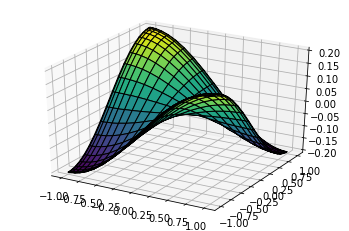

In [55]:
u.vhat[skip,skip] = A.solve(b.rhs)
u.backward()

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(xx,yy,u.v, rstride=1, cstride=1, cmap="viridis",edgecolor="k")
plt.show()

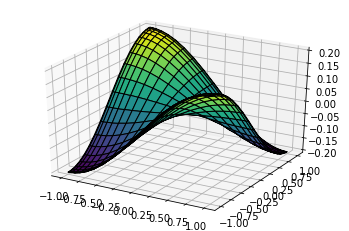

In [56]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(xx,yy,_u(xx,yy), rstride=1, cstride=1, cmap="viridis",edgecolor="k")
plt.show()